In [8]:
from google_play_scraper import reviews, Sort
import pandas as pd

def get_reviews(app_id, app_name):
    result, _ = reviews(
        app_id,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        count=500
    )
    df = pd.DataFrame(result)

    if 'content' not in df.columns:
        raise ValueError(f"Kolom 'content' tidak tersedia untuk {app_name}")

    df['app'] = app_name
    return df[['userName', 'score', 'content', 'at', 'app']]

# Ambil ulasan dari PUBG dan Free Fire
pubg = get_reviews('com.tencent.ig', 'PUBG Mobile')
ff = get_reviews('com.dts.freefireth', 'Free Fire')

# Gabungkan review
all_reviews = pd.concat([pubg, ff])

# Label sentimen
def label_sentiment(score):
    if score > 4:
        return 'positif'
    elif score < 2:
        return 'negatif'
    else:
        return 'netral'

# ✅ Tambahkan kolom sentiment
all_reviews['sentiment'] = all_reviews['score'].apply(label_sentiment)

# Simpan ke Excel
all_reviews.to_excel('ulasan_pubg_vs_freefire.xlsx', index=False)




In [2]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

df = pd.read_excel('ulasan_pubg_vs_freefire.xlsx')

In [ ]:

# --- Unduh resource NLTK (hanya sekali saja, akan diskip jika sudah) ---
nltk.download('stopwords')

# --- Membaca file Excel (.xlsx) ---


# --- Cek kolom yang tersedia ---
print("Kolom dataset:", df.columns)

# --- Kolom yang berisi ulasan: 'content'
text_column = 'content'  # Sudah sesuai dengan dataset kamu

# --- Kamus normalisasi tidak baku ke baku ---
normalization_dict = {
    'gk': 'tidak', 'ga': 'tidak', 'nggak': 'tidak', 'tdk': 'tidak',
    'kmu': 'kamu', 'u': 'kamu', 'aj': 'saja', 'aja': 'saja',
    'sm': 'sama', 'dlm': 'dalam', 'udh': 'sudah', 'bgt': 'banget'
}

# --- Stopwords bahasa Indonesia ---
stop_words = set(stopwords.words('indonesian'))

# --- Stemmer bahasa Indonesia ---
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# --- Tokenizer ---
tokenizer = RegexpTokenizer(r'\w+')

# --- Fungsi Preprocessing Lengkap ---
def preprocess(text):
    if pd.isnull(text):

        return ''
    
    # 1. Case Folding
    text = text.lower()
    
    # 2. Tokenizing (menghapus tanda baca otomatis)
    tokens = tokenizer.tokenize(text)

    # 3. Normalisasi kata tidak baku
    tokens = [normalization_dict.get(token, token) for token in tokens]

    # 4. Stopword Removal
    tokens = [t for t in tokens if t not in stop_words]

    # 5. Stemming
    tokens = [stemmer.stem(token) for token in tokens]

    # 6. Gabungkan kembali
    return ' '.join(tokens)

# --- Terapkan fungsi ke seluruh baris
df['clean_content'] = df[text_column].astype(str).apply(preprocess)

# --- Simpan hasil ke file baru
df.to_excel('ulasan_dibersihkan.xlsx', index=False)

print("✅ Preprocessing selesai! File disimpan sebagai hasil_preprocessing_ulasan.xlsx")

[nltk_data] Downloading package stopwords to /home/frqan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Kolom dataset: Index(['userName', 'score', 'content', 'at', 'app', 'sentiment'], dtype='object')
✅ Preprocessing selesai! File disimpan sebagai hasil_preprocessing_ulasan.xlsx


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# === Diagram Perbandingan Sentimen Sebelum Oversampling ===
if 'app' in df.columns:
    comparison_before = df.groupby(['app', 'sentiment']).size().unstack().fillna(0)
    comparison_before.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
    plt.title("Perbandingan Sentimen: PUBG vs Free Fire")
    plt.ylabel("Jumlah Ulasan")
    plt.xlabel("Game")
    plt.xticks(rotation=0)
    plt.legend(title="Sentimen")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("Kolom 'app' tidak ditemukan untuk perbandingan sebelum oversampling.")

# Baca dan praproses data
df = pd.read_excel('ulasan_dibersihkan.xlsx')
df = df.dropna(subset=['clean_content'])
if 'userName' in df.columns:
    df = df.drop_duplicates(subset=['userName', 'clean_content'])
else:
    df = df.drop_duplicates(subset=['clean_content'])
df = df[df['clean_content'].str.split().str.len() > 1]
df['clean_content'] = df['clean_content'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Mapping label
label_map = {'positif': 1, 'netral': 0, 'negatif': -1}
inv_label_map = {1: 'positif', 0: 'netral', -1: 'negatif'}
df['label'] = df['sentiment'].map(label_map)
df = df.dropna(subset=['label'])



In [13]:
# ========== TF-IDF + OVERSAMPLING ==========
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_content'])
y = df['label']
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X, y)





In [23]:
# === Ekstraksi Fitur TF-IDF ===
feature_names = vectorizer.get_feature_names_out()
tfidf_matrix = X.toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=feature_names)

# Tampilkan 10 fitur TF-IDF teratas berdasarkan total skor tertinggi
top_tfidf = tfidf_df.sum().sort_values(ascending=False).head(10)
print("\n=== 10 Fitur TF-IDF Teratas ===")
print(top_tfidf)



=== 10 Fitur TF-IDF Teratas ===
game      60.151310
bagus     47.929141
nya       37.017759
main      29.556980
seru      26.604944
banget    22.754006
tolong    18.965374
suka      17.346107
pubg      17.099084
burik     16.270505
dtype: float64


In [24]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42, stratify=y_over)


In [16]:
# Naive Bayes training
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [25]:
# === Classification Report ===
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['negatif', 'netral', 'positif']))




=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

     negatif       0.89      0.84      0.86        85
      netral       0.74      0.86      0.80        86
     positif       0.81      0.72      0.76        86

    accuracy                           0.81       257
   macro avg       0.81      0.81      0.81       257
weighted avg       0.81      0.81      0.81       257



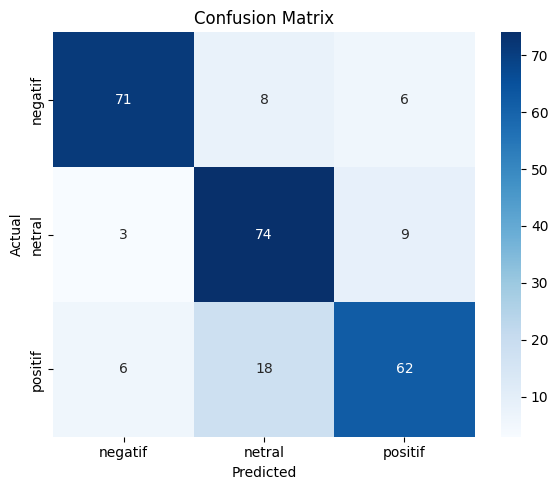

In [26]:
 #  Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif', 'netral', 'positif'], yticklabels=['negatif', 'netral', 'positif'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Ubah label asli menjadi format binarized (one-hot)
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
y_proba = model.predict_proba(X_test)

# Hitung AUC Macro dengan pendekatan One-vs-Rest
auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

print(f"\n=== AUC SCORE (macro-averaged OvR): {auc_score:.4f} ===")



=== AUC SCORE (macro-averaged OvR): 0.9271 ===


In [28]:
# === WordCloud untuk tiap sentimen ===
for label in ['positif', 'netral', 'negatif']:
    text = " ".join(df[df['sentiment'] == label]['clean_content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {label.capitalize()}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [30]:
# Pastikan kolom 'app' dan 'sentiment' tersedia
if 'app' in df.columns and 'sentiment' in df.columns:
    print("\n=== Distribusi Sentimen per Game ===")
    total_per_app = df.groupby('app').size()
    distribusi = df.groupby(['app', 'sentiment']).size().unstack().fillna(0)

    # Hitung persentase
    distribusi_percent = distribusi.div(total_per_app, axis=0) * 100
    distribusi_percent = distribusi_percent.round(2)

    print("\nJumlah Absolut Sentimen per Game:")
    print(distribusi.astype(int))

    print("\nPersentase Sentimen per Game (%):")
    print(distribusi_percent)
else:
    print("Kolom 'app' atau 'sentiment' tidak tersedia dalam dataset.")



=== Distribusi Sentimen per Game ===

Jumlah Absolut Sentimen per Game:
sentiment    negatif  netral  positif
app                                  
Free Fire         97      54      242
PUBG Mobile      127      94      185

Persentase Sentimen per Game (%):
sentiment    negatif  netral  positif
app                                  
Free Fire      24.68   13.74    61.58
PUBG Mobile    31.28   23.15    45.57
